In [3]:
import tensorflow as tf
print(tf.__version__)

2024-08-22 19:04:43.207939: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 19:04:43.535208: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 19:04:43.755068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 19:04:43.927356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 19:04:43.975905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 19:04:44.290225: I tensorflow/core/platform/cpu_feature_gu

2.17.0


In [13]:
import keras

In [14]:
keras.__version__

'3.4.1'

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv

import tensorflow as tf
from keras import models, layers, regularizers
from keras.models import Sequential, save_model,load_model
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.applications import MobileNetV2

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [5]:
import tensorflow as tf

# Check if GPUs are available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs available")

print("Num GPUs Available: ", len(gpus))

No GPUs available
Num GPUs Available:  0


In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [ ]:
load_dotenv()  # Load environment variables from .env file

username = os.getenv("KAGGLE_USERNAME")
kaggle_key = os.getenv("KAGGLE_KEY")

In [8]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":username,"key":kaggle_key}
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d davidvazquezcic/yawn-dataset

Dataset URL: https://www.kaggle.com/datasets/davidvazquezcic/yawn-dataset
License(s): CC-BY-NC-SA-4.0
 77% 13.0M/16.9M [00:01<00:00, 11.4MB/s]
100% 16.9M/16.9M [00:01<00:00, 15.9MB/s]


In [10]:
!unzip yawn-dataset.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/no yawn/2881.jpg   
  inflating: data/no yawn/2882.jpg   
  inflating: data/no yawn/2883.jpg   
  inflating: data/no yawn/2884.jpg   
  inflating: data/no yawn/2885.jpg   
  inflating: data/no yawn/2886.jpg   
  inflating: data/no yawn/2887.jpg   
  inflating: data/no yawn/2888.jpg   
  inflating: data/no yawn/2889.jpg   
  inflating: data/no yawn/2890.jpg   
  inflating: data/no yawn/2891.jpg   
  inflating: data/no yawn/2892.jpg   
  inflating: data/no yawn/2893.jpg   
  inflating: data/no yawn/2894.jpg   
  inflating: data/no yawn/2895.jpg   
  inflating: data/no yawn/2896.jpg   
  inflating: data/no yawn/2897.jpg   
  inflating: data/no yawn/2898.jpg   
  inflating: data/no yawn/2899.jpg   
  inflating: data/no yawn/2900.jpg   
  inflating: data/no yawn/2901.jpg   
  inflating: data/no yawn/2902.jpg   
  inflating: data/no yawn/2903.jpg   
  inflating: data/no yawn/2904.jpg   
  inflating: data/no yawn/2905.jpg   

In [11]:
labels = ['no_yawn', 'yawn']

In [12]:
dir = "data"
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

# Step 1: Create the initial 70% training, 30% remaining split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.3  # 30% remaining for test+validation
)

train_data = datagen.flow_from_directory(
    dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode="grayscale",
    shuffle=True,
    subset='training'  # 70% training
)

# Step 2: Further split the 30% remaining into 20% test and 10% validation
test_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3333  # 1/3rd of the 30% (i.e., 10% of the total data) for validation, 2/3rd for testing
)

validation_data = test_val_datagen.flow_from_directory(
    dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode="grayscale",
    shuffle=True,
    subset='validation'  # 10% validation
)

test_data = test_val_datagen.flow_from_directory(
    dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    color_mode="grayscale",
    shuffle=False,
    subset='training'  # 20% testing
)

Found 3584 images belonging to 2 classes.
Found 1705 images belonging to 2 classes.
Found 3414 images belonging to 2 classes.


In [13]:
train_data.image_shape

(256, 256, 1)

In [14]:
x, y = next(train_data)

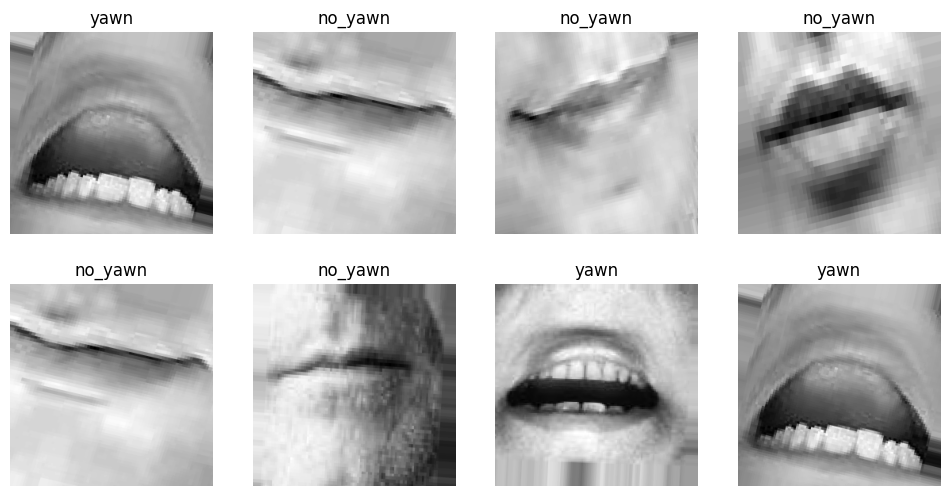

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,6))
for ax in axs.reshape(-1):
    idx = np.random.randint(x.shape[0])
    ax.set_title(labels[int(y[idx])])
    ax.axis('off')
    image = x[idx]*255
    ax.imshow(image[:,:,0], cmap='gray')

In [16]:
def model():
    model = Sequential()
    model.add(Input(shape=train_data.image_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # dropout regularization
    model.add(Dense(1, activation='sigmoid'))

    return model

In [17]:
cnn = model()

# Compiling the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      15,745,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,969 (60.13 MB)

 Trainable params: 15,763,969 (60.13 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
BATCH_SIZE = 16
EPOCHS = 50
CHANNEL = 1

In [20]:
# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5)

# Training the model
cnn.fit(
    train_data, validation_data=validation_data,
    steps_per_epoch=len(train_data) // 32,
    epochs=EPOCHS,
    callbacks=[reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6185 - loss: 3.8457 - val_accuracy: 0.4938 - val_loss: 4.3696 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4544 - loss: 3.2403 - val_accuracy: 0.5126 - val_loss: 0.6798 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 746ms/step - accuracy: 0.5404 - loss: 0.9295 - val_accuracy: 0.6317 - val_loss: 0.6683 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 754ms/step - accuracy: 0.4766 - loss: 0.7211 - val_accuracy: 0.5226 - val_loss: 0.6790 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 898ms/step - accuracy: 0.6667 - loss: 0.6724 - val_accuracy: 0.6516 - val_loss: 0.6606 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6810 - loss: 0.6575 - val_accuracy: 0.6334 - val_loss: 0.6573 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 763ms/step - accuracy: 0.5742 - loss: 0.6709 - val_accuracy: 0.5836 - val_loss: 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9375 - loss: 0.2624 - val_accuracy: 0.7543 - val_loss: 0.5088 - learning_rate: 1.5625e-05
Epoch 39/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8125 - loss: 0.4991
Epoch 39: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 888ms/step - accuracy: 0.8125 - loss: 0.4844 - val_accuracy: 0.7531 - val_loss: 0.5086 - learning_rate: 1.5625e-05
Epoch 40/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 973ms/step - accuracy: 0.8581 - loss: 0.4488 - val_accuracy: 0.7537 - val_loss: 0.5085 - learning_rate: 7.8125e-06
Epoch 41/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8086 - loss: 0.4240 - val_accuracy: 0.7531 - val_loss: 0.5084 - learning_rate: 7.8125e-06
Epoch 42/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8142 - loss: 0.6342
Epoch 42: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 805ms/step - accuracy: 0.8112 - loss: 0.6287 - val_accurac

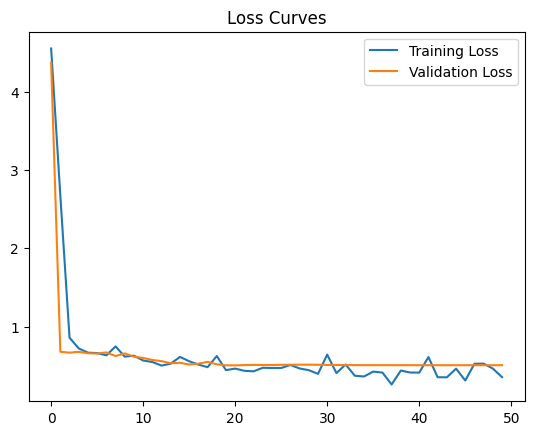

In [21]:
plt.title("Loss Curves")
plt.plot(cnn.history.history['loss'] , label = "Training Loss")
plt.plot(cnn.history.history["val_loss"] , label = "Validation Loss")
plt.legend()

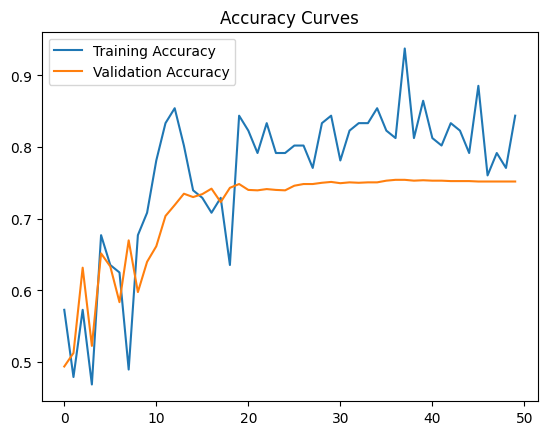

In [22]:
plt.title("Accuracy Curves")
plt.plot(cnn.history.history['accuracy'] , label = "Training Accuracy")
plt.plot(cnn.history.history["val_accuracy"] , label = "Validation Accuracy")
plt.legend()

In [23]:
cnn.evaluate(test_data)

3414/3414 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8342 - loss: 0.4431


[0.38479334115982056, 0.8412419557571411]

In [24]:
cnn.save("yawn_model.keras")

In [27]:
model = load_model("yawn_model.keras")

In [28]:
model.evaluate(test_data)

3414/3414 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8342 - loss: 0.4431


[0.38479334115982056, 0.8412419557571411]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


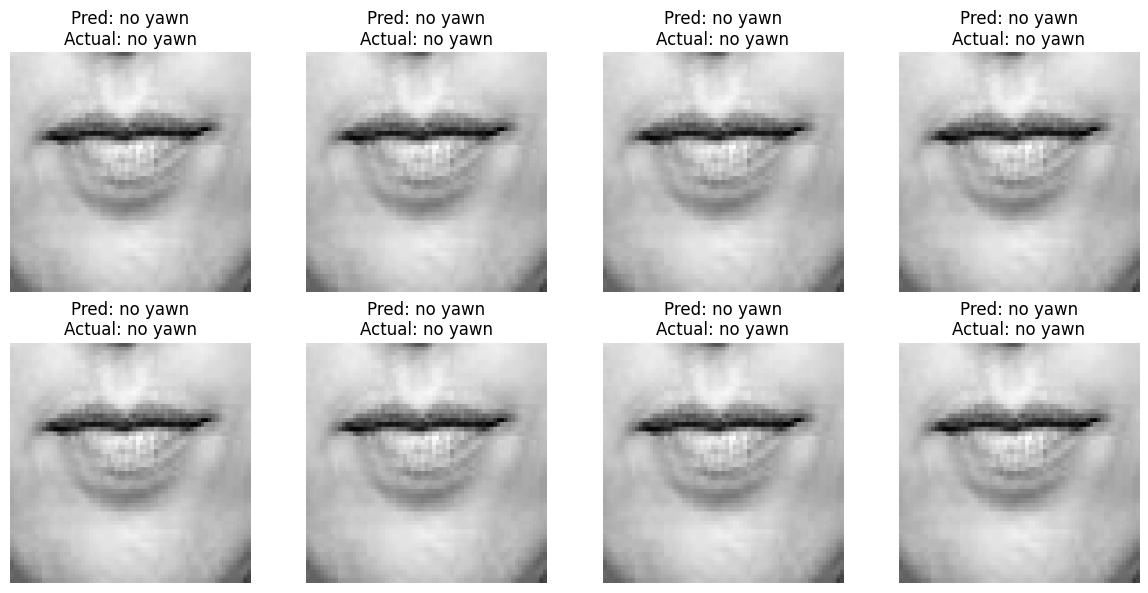

In [29]:
# Load a batch of images and labels from the data
x, y = next(test_data)

# Predict the labels for the batch
predictions = model.predict(x)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

labels = ['no yawn', 'yawn']

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for ax in axs.reshape(-1):
    idx = np.random.randint(x.shape[0])
    actual_label = labels[int(y[idx])]
    predicted_label = labels[int(predicted_labels[idx])]

    ax.set_title(f"Pred: {predicted_label}\nActual: {actual_label}")
    ax.axis('off')
    image = x[idx] * 255
    ax.imshow(image[:, :, 0], cmap='gray')

plt.tight_layout()
plt.show()

In [30]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

3414/3414 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8342 - loss: 0.4431
Test Accuracy: 0.8412


In [42]:
y_true = test_data.classes

predictions = model.predict(test_data)
y_hat = (predictions>0.5).astype(int).reshape(-1)

3414/3414 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


In [43]:
y_true, y_hat

(array([0, 0, 0, ..., 1, 1, 1], dtype=int32), array([0, 0, 0, ..., 1, 0, 0]))

In [46]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_hat))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1728
           1       0.84      0.84      0.84      1686

    accuracy                           0.84      3414
   macro avg       0.84      0.84      0.84      3414
weighted avg       0.84      0.84      0.84      3414



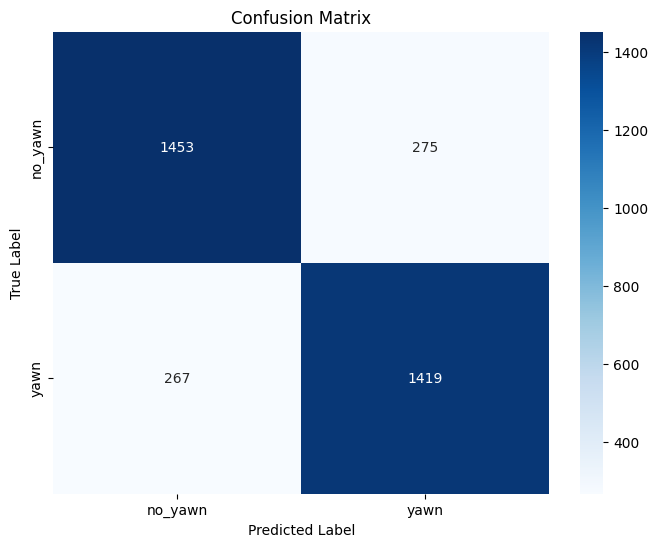

In [49]:
labels = ['no_yawn', 'yawn']
# Confusion matrix
cf_matrix = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()